In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
# additional torch packages
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torchvision.transforms import ToTensor
import os
from glob import glob
from PIL import Image
import time
import torch
# # import unet
# import unet_architecture



In [ ]:
class Unet(nn.Module):
    def __init__(self, n_class, dropout_rate=0.3):
        super(Unet, self).__init__()

        # Encoder (downsampling)
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)

        # Decoder (upsampling)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn11d = nn.BatchNorm2d(512)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(512)
        # self.dropout1d = nn.Dropout2d(p=dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(256)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(256)
        # self.dropout2d = nn.Dropout2d(p=dropout_rate)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(128)
        # self.dropout3d = nn.Dropout2d(p=dropout_rate)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(64)
        # self.dropout4d = nn.Dropout2d(p=dropout_rate)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.bn11d(self.d11(xu11)))
        xd12 = F.relu(self.bn12d(self.d12(xd11)))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32[:, :, :xu2.size(2), :xu2.size(3)]], dim=1)
        xd21 = F.relu(self.bn21d(self.d21(xu22)))
        xd22 = F.relu(self.bn22d(self.d22(xd21)))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22[:, :, :xu3.size(2), :xu3.size(3)]], dim=1)
        xd31 = F.relu(self.bn31d(self.d31(xu33)))
        xd32 = F.relu(self.bn32d(self.d32(xd31)))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12[:, :, :xu4.size(2), :xu4.size(3)]], dim=1)
        xd41 = F.relu(self.bn41d(self.d41(xu44)))
        xd42 = F.relu(self.bn42d(self.d42(xd41)))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def add_noise_to_tensor(image_tensor, noise_range=(-1, 1)):
    # Convert to floating-point tensor
    image_tensor = image_tensor.float()

    # Get the shape of the input tensor
    shape = image_tensor.shape

    # Generate random variables for each pixel within the specified range
    random_variables = torch.rand(shape, device = image_tensor.device) * (noise_range[1] - noise_range[0]) + noise_range[0]

    # Add noise to the image tensor element-wise
    noisy_image = image_tensor + random_variables * torch.std(image_tensor)

    return noisy_image

In [ ]:
# GPU
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x
def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

net = Unet(n_class=3)
if use_cuda:
    net.cuda()

device = torch.device("cuda" if use_cuda else "cpu")  # use cuda or cpu
# net.to(device)

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)



image_path = '/content/drive/MyDrive/DeepLearning/data'
label_path = '/content/drive/MyDrive/DeepLearning/labels'

images_tensors = []
labels_tensors = []

# Getting a sorted list of filenames from both image and label directories
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

# Zipping the sorted filenames so they correspond to each other
for img_filename, lbl_filename in zip(image_files, label_files):
    if img_filename[9:12] == lbl_filename[7:10]:  # Matching filenames by position
        img_filepath = os.path.join(image_path, img_filename)
        lbl_filepath = os.path.join(label_path, lbl_filename)

        # Reading and converting images to tensors
        single_image = Image.open(img_filepath)
        single_image = ToTensor()(single_image)
        images_tensors.append(single_image)

        # Reading and converting labels to tensors
        single_label = Image.open(lbl_filepath)
        single_label = ToTensor()(single_label)
        labels_tensors.append(single_label)


In [ ]:
images_float = [image.type(torch.FloatTensor) for image in images_tensors]
# make labels integers 0, 1, 2
labels_int = [label * 2 for label in labels_tensors]
# convert labels_cropped to be long tensor
labels_long = [label.long() for label in labels_int]
# remove the third dimension from labels
#labels_long = [label.squeeze(0) for label in labels_long]

max_pixel = torch.max(torch.stack(images_float[0:400]))
# Normalize the images
images_normalized = [image / max_pixel for image in images_float]

In [ ]:
# Build Tensor dataset
dataset = TensorDataset(torch.stack(images_normalized), torch.stack(labels_long))

# Split in train (80%), validation (10%) and test (10%) sets
train_size = int(0.06 * len(dataset))
val_size = int(0.84 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Crop images and labels to 128x128 and 256x256
transform_train = transforms.CenterCrop((128, 128))
transform_val_test = transforms.CenterCrop((256, 256))


In [ ]:
# apply transforms to train, val and test sets for the images and labels
train_set_cropped = [(transform_train(image), transform_train(label)) for image, label in train_set]
val_set_cropped = [(transform_val_test(image), transform_val_test(label)) for image, label in val_set]
test_set_cropped = [(transform_val_test(image), transform_val_test(label)) for image, label in test_set]

In [ ]:
# add noise to training images
train_set_cropped_noisy = [(add_noise_to_tensor(image), label) for image, label in train_set_cropped]
val_set_cropped_noisy = [(add_noise_to_tensor(image), label) for image, label in val_set_cropped]

# train_set_cropped_noisy = train_set_cropped
# val_set_cropped_noisy = val_set_cropped

print('shape of training set images: ', train_set_cropped_noisy[0][0].shape)

shape of training set images:  torch.Size([1, 128, 128])


In [ ]:
# Define data augmentation transformations
hflip  = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),   # Randomly flip the image horizontally

])

# Define data augmentation transformations
rot180  = transforms.Compose([
    transforms.RandomRotation(degrees=[180, 180]), # Randomly rotate the image by a certain degree
])

# Define data augmentation transformations
rot90  = transforms.Compose([
    transforms.RandomRotation(degrees=[90, 90]), # Randomly rotate the image by a certain degree
])

In [ ]:
# apply transforms to train sets for the images and labels
train_set_cropped_hflip = [(hflip(image), hflip(label)) for image, label in train_set_cropped_noisy]
train_set_cropped_rot180 = [(rot180(image), rot180(label)) for image, label in train_set_cropped_noisy]
train_set_cropped_rot90 = [(rot90(image), rot90(label)) for image, label in train_set_cropped_noisy]

#combine all the training sets
train_set_cropped_noisy.extend(train_set_cropped_hflip)
train_set_cropped_noisy.extend(train_set_cropped_rot180)
train_set_cropped_noisy.extend(train_set_cropped_rot90)

# remove the third dimension from labels in train_set_cropped_noisy
train_set_cropped_noisy = [(image, label.squeeze(0)) for image, label in train_set_cropped_noisy]
val_set_cropped_noisy = [(image, label.squeeze(0)) for image, label in val_set_cropped_noisy]

In [ ]:
# batch size
batch_size = 4

# Build data loaders
train_loader = DataLoader(train_set_cropped_noisy, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_cropped_noisy, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set_cropped, batch_size=batch_size, shuffle=False)

In [ ]:
loss_unet = nn.CrossEntropyLoss()

# optimizer: ADAM
optimizer_unet = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet, 'min', patience=2)

# number of epochs to train the model
n_epochs = 50

# function to calculate accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0) * labels.size(1) * labels.size(2)
    correct = (predicted == labels).sum().item()
    return correct / total


In [ ]:
# Initialize lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    # Training
    net.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_loader:
        images, labels = get_variable(images), get_variable(labels)

        optimizer_unet.zero_grad()

        outputs = net(images)
        loss = loss_unet(outputs, labels)
        loss.backward()
        optimizer_unet.step()

        train_loss += loss.item() * images.size(0)
        train_acc += accuracy(outputs, labels) * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)

    # Store training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = get_variable(images), get_variable(labels)
            outputs = net(images)
            loss = loss_unet(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += accuracy(outputs, labels) * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)

    # Store validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch + 1}/{n_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


    # save my trained model
    PATH = './unet_model.pth'
    torch.save(net.state_dict(), PATH)


Epoch [1/50]
Training Loss: 1.0475, Training Accuracy: 0.4750
Validation Loss: 0.9688, Validation Accuracy: 0.5598
Epoch [2/50]
Training Loss: 0.7911, Training Accuracy: 0.6792
Validation Loss: 0.5612, Validation Accuracy: 0.8657
Epoch [3/50]
Training Loss: 0.6160, Training Accuracy: 0.8208
Validation Loss: 0.4571, Validation Accuracy: 0.8938
Epoch [4/50]
Training Loss: 0.5042, Training Accuracy: 0.8846
Validation Loss: 0.4072, Validation Accuracy: 0.9224
Epoch [5/50]
Training Loss: 0.4339, Training Accuracy: 0.9133
Validation Loss: 0.3567, Validation Accuracy: 0.9433
Epoch [6/50]
Training Loss: 0.3865, Training Accuracy: 0.9303
Validation Loss: 0.3272, Validation Accuracy: 0.9451
Epoch [7/50]
Training Loss: 0.3514, Training Accuracy: 0.9409
Validation Loss: 0.3062, Validation Accuracy: 0.9501
Epoch [8/50]
Training Loss: 0.3321, Training Accuracy: 0.9468
Validation Loss: 0.2953, Validation Accuracy: 0.9554
Epoch [9/50]
Training Loss: 0.3091, Training Accuracy: 0.9519
Validation Loss: 0

Text(50, 0.1900645131156558, '0.1901')

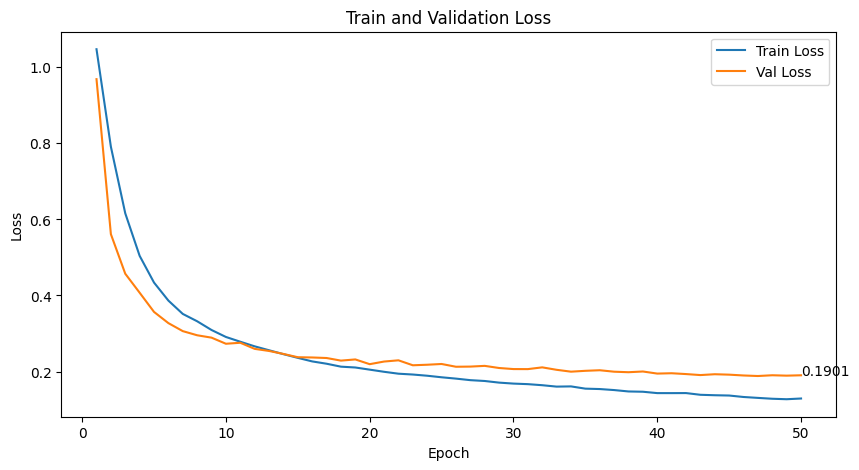

In [ ]:
# Plot the train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# show val loss as text on plot for last epoch
plt.text(n_epochs, val_losses[-1], f'{val_losses[-1]:.4f}')
#plt.savefig('figures/unet_loss.png')

Text(50, 0.9569965180896577, '0.9570')

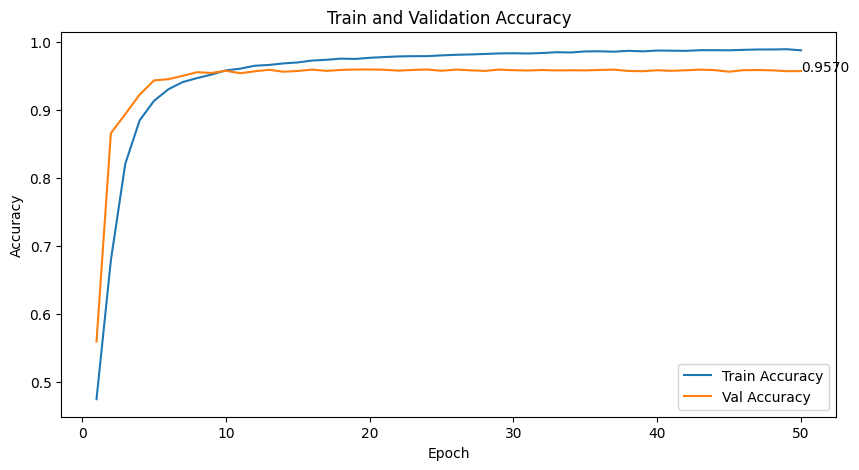

In [ ]:
# Plot the train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
# show val accuracy as text on plot for last epoch
plt.text(n_epochs, val_accuracies[-1], f'{val_accuracies[-1]:.4f}')
#plt.savefig('figures/unet_accuracy.png')

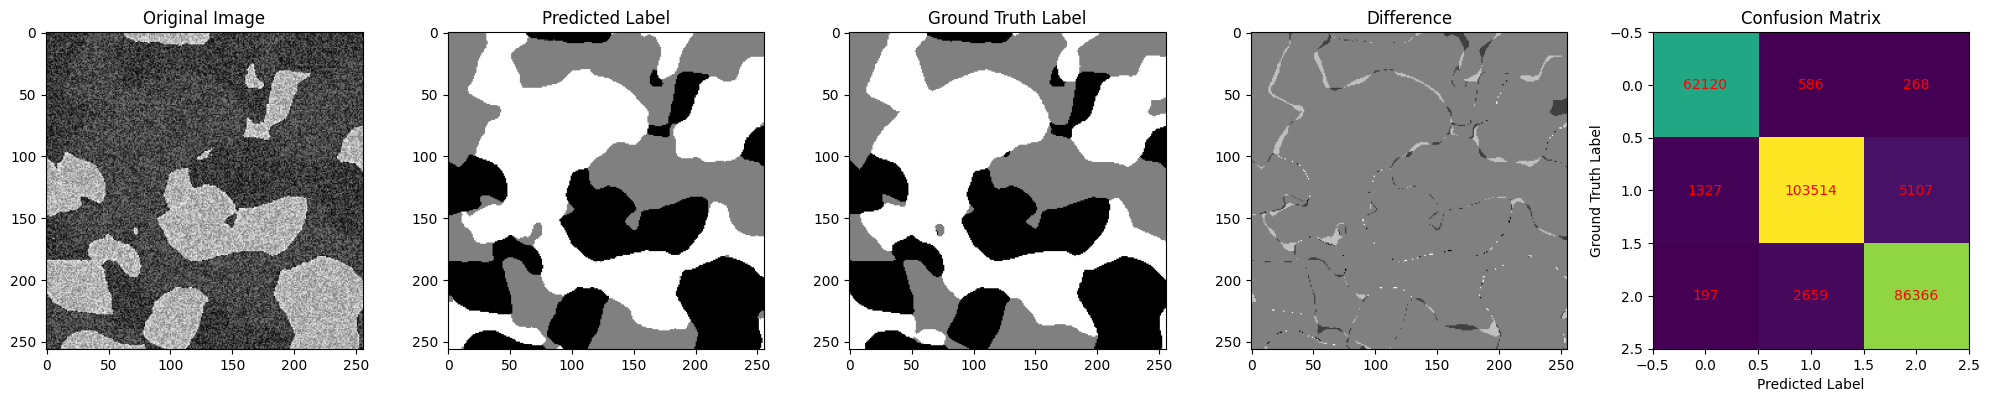

In [ ]:
# plot 1 image from validation set with original, predicted, ground truth labels and (predicted - ground truth) labels
net.eval()
images, labels = next(iter(val_loader))
images, labels = get_variable(images), get_variable(labels)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
predicted = predicted.squeeze(1)
predicted = predicted.cpu().numpy()
labels = labels.squeeze(1)
labels = labels.cpu().numpy()
images = images.cpu().numpy()
images = np.transpose(images, (0, 2, 3, 1))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axes[0].imshow(images[1], cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(predicted[1], cmap="gray")
axes[1].set_title('Predicted Label')
axes[2].imshow(labels[1], cmap="gray")
axes[2].set_title('Ground Truth Label')
axes[3].imshow(labels[1] - predicted[1], cmap="gray")
axes[3].set_title('Difference')
# visualize the confusion matrix for the predicted and ground truth labels
confusion_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        confusion_matrix[i, j] = np.sum((predicted == i) & (labels == j))
axes[4].imshow(confusion_matrix)
# show actual numbers in confusion matrix
for i in range(3):
    for j in range(3):
        axes[4].text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="red")
axes[4].set_title('Confusion Matrix')
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('Ground Truth Label')
plt.tight_layout()
#plt.savefig('figures/unet_results_visually.png')

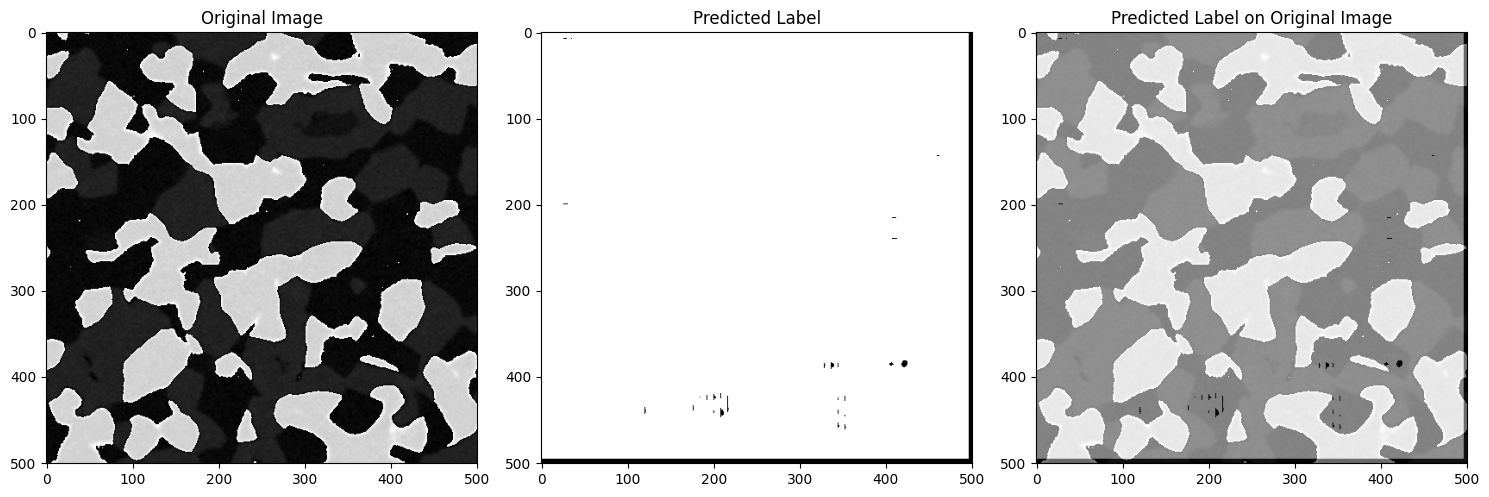

In [ ]:
import torch
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt

# Assuming your neural network class is named 'YourNetworkClass'
#net = YourNetworkClass()
net = Unet(n_class=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

net.load_state_dict(torch.load(PATH))
net.eval()

# Load the test image
test_image_path = '/content/drive/MyDrive/DeepLearning/data/SOCprist0009.tiff'
test_image = Image.open(test_image_path)

# Convert the normalized image to a PyTorch tensor
test_image_max = np.max(np.array(test_image))
test_image = ToTensor()(test_image).type(torch.FloatTensor) / test_image_max
test_image = test_image.unsqueeze(0).to(device)

# Define patch size and target output size
patch_size = (128, 128)
target_size = (501, 501)

# Calculate stride to achieve the target output size
stride = (
    max((test_image.shape[2] - patch_size[0]) // (target_size[0] - 1), 8),
    max((test_image.shape[3] - patch_size[1]) // (target_size[1] - 1), 8)
)

# Initialize an empty array for storing predictions
predicted_labels = np.zeros_like(test_image.cpu().numpy())

for i in range(0, test_image.shape[3] - patch_size[1] + 1, stride[1]):
    for j in range(0, test_image.shape[2] - patch_size[0] + 1, stride[0]):
        image_patch = test_image[:, :, j:j + patch_size[0], i:i + patch_size[1]]

        # Perform inference
        with torch.no_grad():
            output = net(image_patch)

            _,predicted = torch.min(output,1)
            predicted = predicted.squeeze(1)

            # Update the corresponding region in the predicted_labels array
        predicted_labels[:, :, j:j + patch_size[0], i:i + patch_size[1]] = predicted.cpu().numpy()
            #print(predicted_labels)
        a = predicted_labels
# print(predicted.shape)

# Convert the predicted labels to an image
predicted_labels = predicted_labels.squeeze(0).squeeze(0).astype(np.uint8)
predicted_labels = Image.fromarray(predicted_labels)


# Plot the original image, predicted labels, and overlay
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(test_image.cpu().numpy()[0, 0, :, :], cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(predicted_labels, cmap="gray")
axes[1].set_title('Predicted Label')
axes[2].imshow(test_image.cpu().numpy()[0, 0, :, :], cmap="gray")
axes[2].imshow(predicted_labels, cmap="gray", alpha=0.5)
axes[2].set_title('Predicted Label on Original Image')
plt.tight_layout()
plt.show()